# Generative Deep Learning
# CIFAR 10 - Feedforward Network

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.datasets as datasets
from torchvision import transforms

from sklearn.metrics import classification_report, confusion_matrix

from itertools import islice as take

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [3]:
data_tsfm = transforms.Compose([transforms.ToTensor()])
cifar_train = datasets.CIFAR10('data/cifar10', train=True, transform=data_tsfm, target_transform=None, download=True)

Files already downloaded and verified


## Describe Data

In [4]:
print(f'Data source: {cifar_train.url}')
print(f'Training examples and size: {cifar_train.data.shape, type(cifar_train.data)}')
print(f'Number of Classes: {len(cifar_train.classes)}')
print(f'Classes: {cifar_train.classes}')

Data source: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Training examples and size: ((50000, 32, 32, 3), <class 'numpy.ndarray'>)
Number of Classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
classes = cifar_train.classes

In [6]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8,5))
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

## Display some images

image size: (32, 32, 3) dtype=uint8


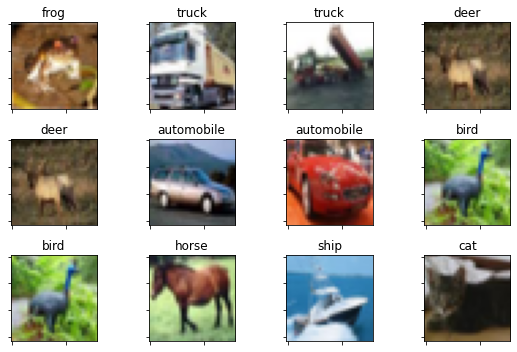

In [7]:
images, labels = [], []
for i in range(12):
    x_item, y_item = cifar_train.data[i] , classes[cifar_train.targets[i]]
    images.append(x_item)
    labels.append(y_item)


print(f'image size: {images[0].shape} dtype={images[0].dtype}')
titles = [str(y_item) for y_item in labels]
display_grid(images, titles, 3, 4)

## Definig the Model

In [244]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv_1 = nn.Conv2d(3, 32, (3,3), stride=1, padding=1) # [N, 3, 32, 32] => [N, 32, 32, 32]
        self.bn_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.LeakyReLU(0.1)
        
        self.conv_2 = nn.Conv2d(32, 32, (3,3), stride=2, padding=1) # [N, 32, 32, 32] => [N, 32, 16, 16]
        self.bn_2 = nn.BatchNorm2d(32)
        self.relu_2 = nn.LeakyReLU(0.1)
        
        self.conv_3 = nn.Conv2d(32, 64, (3,3), stride=1, padding=1) # [N, 32, 16, 16] => [N, 64, 16, 16]
        self.bn_3 = nn.BatchNorm2d(64)
        self.relu_3 = nn.LeakyReLU(0.1)
        
        self.conv_4 = nn.Conv2d(64, 64, (3,3), stride=2, padding=1) # [N, 64, 16, 16] => [N, 64, 8, 8]
        self.bn_4 = nn.BatchNorm2d(64)
        self.relu_4 = nn.LeakyReLU(0.1)
        
        self.flatten = nn.Flatten() # [N, 64, 8, 8] => [N, 64*8*8]
        
        self.forward_block = nn.Sequential(
            nn.Linear(64*8*8, 128), # [N, 64, 8, 8] => [N, 128]
            #nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, 10), # [N, 128] => [N, 10]
            nn.Softmax(dim=1)
        )
    
    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.relu_1(x)
        
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)

        x = self.conv_3(x)
        x = self.bn_3(x)
        x = self.relu_3(x)
        
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = self.relu_4(x)
        
        x = self.flatten(x)
        x = self.forward_block(x)
        
        return x

In [245]:
device = torch.device("cpu")
print(device)

cpu


In [246]:
model = ConvNet()
model.to(device)
print(summary(model, (3,32,32), device='cpu', verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─LeakyReLU: 1-3                         [-1, 32, 32, 32]          --
├─Conv2d: 1-4                            [-1, 32, 16, 16]          9,248
├─BatchNorm2d: 1-5                       [-1, 32, 16, 16]          64
├─LeakyReLU: 1-6                         [-1, 32, 16, 16]          --
├─Conv2d: 1-7                            [-1, 64, 16, 16]          18,496
├─BatchNorm2d: 1-8                       [-1, 64, 16, 16]          128
├─LeakyReLU: 1-9                         [-1, 64, 16, 16]          --
├─Conv2d: 1-10                           [-1, 64, 8, 8]            36,928
├─BatchNorm2d: 1-11                      [-1, 64, 8, 8]            128
├─LeakyReLU: 1-12                        [-1, 64, 8, 8]            --
├─Flatten: 1-13                          [-1, 4096]                --
├

### Test imput-output shapes

In [232]:
x_fake = torch.zeros(1, 3, 32, 32)
y_fake = model(x_fake)
print(f'INPUT:{x_fake.shape} => OUTPUT:{y_fake.shape}')

INPUT:torch.Size([1, 3, 32, 32]) => OUTPUT:torch.Size([1, 10])


## Train Data Loader

In [233]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=cifar_train, batch_size=BATCH_SIZE, shuffle=True)
for x, y in take(train_loader, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'X mean: {x.mean():.4f}, X std: {x.std():.4f}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
X mean: 0.4972, X std: 0.2466
y shape=torch.Size([32]) dtype=torch.int64


## Training

In [253]:
%%time

EPOCHS = 10
LEARNING_RATE = 0.0005
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() # clear residual gradients 
        
        y_pred = model(X_batch)
        
        #print('\n')
        #print(y_pred.shape)
        #print(y_pred[0])
        
        #print(y_batch.shape)
        #print(y_batch)
        
        
        loss_calc = loss(y_pred, y_batch)

        
        loss_calc.backward()
        optimizer.step()
        
        epoch_loss += loss_calc.item()

        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

Epoch 001: | Loss: 2.02686
Epoch 002: | Loss: 1.92553
Epoch 003: | Loss: 1.87005
Epoch 004: | Loss: 1.83526
Epoch 005: | Loss: 1.80359
Epoch 006: | Loss: 1.77553
Epoch 007: | Loss: 1.75227
Epoch 008: | Loss: 1.73924
Epoch 009: | Loss: 1.72011
Epoch 010: | Loss: 1.70787
CPU times: user 32min 30s, sys: 2.25 s, total: 32min 33s
Wall time: 8min 8s


# Comparing with Test Set

## Loading Test Data

In [254]:
transforms.Compose([transforms.ToTensor()])
cifar_test = datasets.CIFAR10('data/cifar10',
                              train=False,
                              transform=data_tsfm,
                              target_transform=None,
                              download=True)

Files already downloaded and verified


In [255]:
print(f'Data source: {cifar_test.url}')
print(f'Training examples and size: {cifar_test.data.shape, type(cifar_test.data)}')
print(f'Number of Classes: {len(cifar_test.classes)}')
print(f'Classes: {cifar_test.classes}')

Data source: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Training examples and size: ((10000, 32, 32, 3), <class 'numpy.ndarray'>)
Number of Classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Test Data Loader

In [256]:
test_loader = DataLoader(dataset=cifar_test, batch_size=BATCH_SIZE, shuffle=True)
for x, y in take(test_loader, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## Predictions

In [257]:
x_tensors = []
y_true_labels = []
y_pred_labels = []


model.eval()
accs = []
t = 1
with torch.no_grad():
    for X_batch, y_true in test_loader:
        #print(t)
        X_batch = X_batch.to(device)
        
        y_logits = model(X_batch)
        y_prob = F.softmax(y_logits, 1)
        y_pred = torch.argmax(y_prob, 1)
        
        
        acc = (y_true == y_pred).type(torch.float32).mean()
        accs.append(acc.item() * 100)
        
        #print('\n')
        #print(y_test_pred.shape)
        #print(y_test_pred[0])
                            
        x_tensors.append(X_batch)
        y_true_labels.append(y_true)
        y_pred_labels.append(y_pred)
        
        
        t += 1
        
    acc = np.mean(accs)

#y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#y_pred = [np.argmax(p) for p in y_pred_list]

print(f'Predicted instances: {len(y_pred_labels)}')
print(f'Exactitud = {acc:.2f}')

Predicted instances: 313
Exactitud = 70.42


In [259]:
y_pred = [t.numpy() for t in y_pred_labels]
y_pred = np.hstack(y_pred)
print(y_pred.shape)
print(y_pred)

(10000,)
[3 6 4 ... 2 8 5]


In [260]:
y_true = [t.numpy() for t in y_true_labels]
y_true = np.hstack(y_true)
print(y_true.shape)
print(y_true)

(10000,)
[3 6 5 ... 2 8 2]


In [261]:
x_images = []
for T in x_tensors:
    for t in T:
        t = t.permute(1, 2, 0)
        x_images.append(t)

## Accuracy and Confusion Matrix

Accuracy: 0.7042

              precision    recall  f1-score   support

    airplane       0.70      0.79      0.74      1000
  automobile       0.74      0.88      0.81      1000
        bird       0.68      0.52      0.59      1000
         cat       0.55      0.47      0.51      1000
        deer       0.68      0.64      0.66      1000
         dog       0.68      0.56      0.62      1000
        frog       0.64      0.89      0.74      1000
       horse       0.87      0.67      0.76      1000
        ship       0.69      0.91      0.78      1000
       truck       0.86      0.71      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



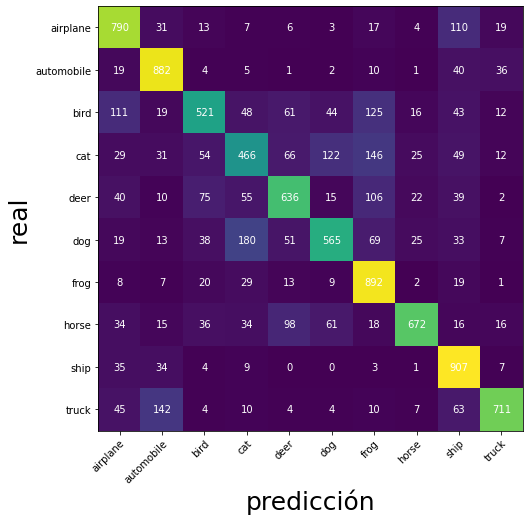

In [262]:
print(f'Accuracy: {(np.array(y_true) == y_pred).sum() / len(y_true)}')

print(f'\n{classification_report(y_true, y_pred, target_names=classes)}')
c_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(c_matrix) #cmap='gist_gray'
# We want to show all ticks...
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, c_matrix[i, j],
                       ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.xlabel('predicción', fontsize=25)
plt.ylabel('real', fontsize=25)
plt.show()

## Plot Test examples

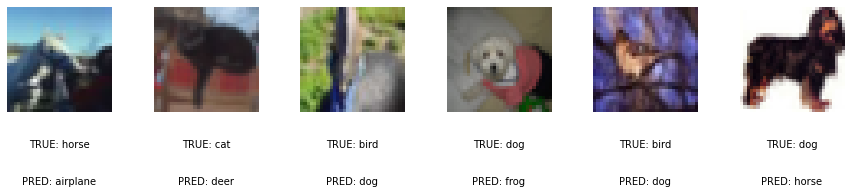

In [263]:
n_to_show = 6
indices = np.random.choice(range(len(x_images)), n_to_show)
fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_images[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'TRUE: '+classes[y_true[idx]], fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'PRED: '+classes[y_pred[idx]], fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)